In [1]:
import article
import pandas as pd
from metrics import forecast, indicators
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
money_control_articles = article.load_articles("data/news/money-control-articles-formatted")
economic_times_articles = article.load_articles("data/news/economic-times-articles-formatted")
live_mint_articles = article.load_articles("data/news/live-mint-articles-formatted")
articles = money_control_articles
articles.extend(economic_times_articles)
articles.extend(live_mint_articles)
len(articles)

7046

In [3]:
content = []
for a in articles:
    if a.cleaned_content == "you can now subscribe to our economic times whatsapp channel":
        continue

    senti = a.sentiment()
    content.append({
        "timestamp": pd.to_datetime(a.market_timestamp),
        "content": a.cleaned_content,
        "pos_senti": senti["pos"],
        "neu_senti": senti["neu"],
        "neg_senti": senti["neg"],
        "compound_senti": senti["compound"],
    })
content = pd.DataFrame(content)
content

,timestamp,content,pos_senti,neu_senti,neg_senti,compound_senti
0,2024-02-20 12:16:00+05:30,e commerce company amazon on tuesday said it h...,0.095,0.894,0.012,0.8575
1,2024-03-28 09:15:00+05:30,reliance power on wednesday said its two subsi...,0.104,0.816,0.081,0.7579
2,2024-04-29 13:27:00+05:30,kundan green energy on monday said it has secu...,0.101,0.899,0.000,0.8807
3,2024-05-01 15:05:00+05:30,eicher motors ltd on wednesday said its arm ve...,0.000,1.000,0.000,0.0000
4,2024-08-05 12:36:00+05:30,the countrys largest airline indigo will launc...,0.015,0.985,0.000,0.2960
...,...,...,...,...,...,...
3203,2024-09-24 14:42:00+05:30,shares of popular foundations debuted with a l...,0.157,0.826,0.017,0.9944
3204,2024-10-17 14:56:00+05:30,blue cloud softech solutions shares dropped ov...,0.143,0.844,0.013,0.9891
3205,2024-10-03 10:02:00+05:30,unilex colours and chemicals ipo listing share...,0.103,0.877,0.020,0.9800
3206,2024-10-03 10:21:00+05:30,stock market today shares of oil gas producers...,0.103,0.788,0.110,-0.7840


In [4]:
def create_sequences(data, X, time_steps=10):
    assert "Close" in data.columns, "Close not found in data"

    assert "timestamp" in X.columns, "timestamp not found in X"

    d = data[["Close"]]

    no_data_indices = []

    X_seq = []
    for i in X.index:
        end_timestamp = X["timestamp"][i]
        idx = data.index[data['Datetime'] == end_timestamp].tolist()[0]

        sub = d[idx - time_steps:idx]
        if len(sub) == 0:
            no_data_indices.append(i)
            continue

        X_seq.append(sub)
    
    return np.array(X_seq), no_data_indices

In [5]:
stock_data = pd.read_csv("data/stock-prices/ASHOKLEY.NS.csv")

stock_scaler = StandardScaler()

engulfing = indicators.engulfing(stock_data)
marubozo = indicators.marubozo(stock_data)
doji = indicators.doji(stock_data)
hammer = indicators.hammer(stock_data)
inverted_hammer = indicators.inverted_hammer(stock_data)
macd = indicators.macd(stock_data)
rsi = indicators.rsi(stock_data)

stock_data[["Close"]] = stock_scaler.fit_transform(stock_data[["Close"]])

stock_data = pd.concat([stock_data, engulfing, marubozo, doji, hammer, inverted_hammer, macd, rsi, forecast.precise_forecast(stock_data)], axis=1)
# stock_data.drop("Datetime", axis=1, inplace=True)
stock_data.dropna(inplace=True)
stock_data.index = range(len(stock_data))

enc = OneHotEncoder()
engulfing = enc.fit_transform(np.reshape(stock_data["engulfing"], (-1, 1)))
engulfing_enc = pd.DataFrame(engulfing.toarray())
engulfing_enc.columns = enc.get_feature_names_out(["engulfing"])

enc = OneHotEncoder()
marubozo = enc.fit_transform(np.reshape(stock_data["marubozo"], (-1, 1)))
marubozo_enc = pd.DataFrame(marubozo.toarray())
marubozo_enc.columns = enc.get_feature_names_out(["marubozo"])

stock_data = pd.concat([stock_data, engulfing_enc, marubozo_enc], axis=1)
stock_data.drop(["engulfing", "marubozo"], axis=1, inplace=True)

span_1 = forecast.precise_forecast(stock_data, span=1)
span_2 = forecast.precise_forecast(stock_data, span=2)
span_5 = forecast.precise_forecast(stock_data, span=5)
span_10 = forecast.precise_forecast(stock_data, span=10)
span_30 = forecast.precise_forecast(stock_data, span=30)
stock_data = pd.concat([stock_data, span_1, span_2, span_5, span_10, span_30], axis=1)
stock_data.dropna(inplace=True)
stock_data["Datetime"] = pd.to_datetime(stock_data["Datetime"])
stock_data

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,doji,hammer,...,engulfing_bullish,engulfing_none,marubozo_bearish,marubozo_bullish,marubozo_none,precise_forecast_1,precise_forecast_2,precise_forecast_5,precise_forecast_10,precise_forecast_30
0,2024-08-12 09:16:00+05:30,250.800003,250.949997,250.050003,0.493925,88855,0.0,0.0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.564329,0.571739,0.582856,0.619911,0.631027
1,2024-08-12 09:17:00+05:30,250.399994,251.350006,250.399994,0.564329,131111,0.0,0.0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.571739,0.542096,0.642143,0.642143,0.656966
2,2024-08-12 09:18:00+05:30,251.350006,251.500000,250.949997,0.571739,111317,0.0,0.0,0,1,...,0.0,1.0,0.0,0.0,1.0,0.542096,0.553212,0.645849,0.638438,0.697725
3,2024-08-12 09:19:00+05:30,251.300003,251.600006,251.050003,0.542096,265162,0.0,0.0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.553212,0.582856,0.619911,0.631027,0.716252
4,2024-08-12 09:20:00+05:30,250.800003,251.350006,250.800003,0.553212,113967,0.0,0.0,0,0,...,0.0,1.0,0.0,0.0,1.0,0.582856,0.642143,0.597678,0.671787,0.694020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14920,2024-10-18 14:45:00+05:30,223.380005,223.399994,223.270004,-1.507024,7515,0.0,0.0,0,1,...,0.0,1.0,0.0,0.0,1.0,-1.509988,-1.509248,-1.510729,-1.501836,-1.503319
14921,2024-10-18 14:46:00+05:30,223.389999,223.389999,223.250000,-1.509988,7058,0.0,0.0,0,1,...,0.0,1.0,0.0,0.0,1.0,-1.509248,-1.503319,-1.513694,-1.504059,-1.499613
14922,2024-10-18 14:47:00+05:30,223.339996,223.490005,223.339996,-1.509248,11101,0.0,0.0,0,0,...,0.0,1.0,0.0,0.0,1.0,-1.503319,-1.515176,-1.515176,-1.509988,-1.505542
14923,2024-10-18 14:48:00+05:30,223.500000,223.500000,223.339996,-1.503319,6081,0.0,0.0,0,0,...,0.0,1.0,0.0,0.0,1.0,-1.515176,-1.510729,-1.509248,-1.509988,-1.513694


In [6]:
data = pd.merge(stock_data, content, left_on='Datetime', right_on='timestamp', how='inner')
data["market_minutes"] = data["timestamp"].apply(lambda x: (x.timestamp() / 60) % 1440 - 225)
data.head()

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,doji,hammer,...,precise_forecast_5,precise_forecast_10,precise_forecast_30,timestamp,content,pos_senti,neu_senti,neg_senti,compound_senti,market_minutes
0,2024-08-13 09:15:00+05:30,253.350006,253.350006,252.699997,0.675493,101679,0.0,0.0,0,0,...,0.582856,0.820006,0.768130,2024-08-13 09:15:00+05:30,senior executive churn continued at it giant w...,0.042,0.914,0.044,0.1280,0.0
1,2024-08-13 11:27:00+05:30,253.500000,253.649994,253.500000,0.731075,11180,0.0,0.0,0,0,...,0.731075,0.742191,0.705136,2024-08-13 11:27:00+05:30,from autonomous driving and sdv software defin...,0.042,0.958,0.000,0.9062,132.0
2,2024-08-13 12:26:00+05:30,252.850006,253.000000,252.699997,0.682903,8722,0.0,0.0,0,0,...,0.675493,0.686609,0.649554,2024-08-13 12:26:00+05:30,after losing the manufacturing plants of benga...,0.111,0.857,0.032,0.9863,191.0
3,2024-08-14 09:15:00+05:30,251.949997,252.000000,251.449997,0.575445,45700,0.0,0.0,0,0,...,0.519863,0.560623,0.467987,2024-08-14 09:15:00+05:30,wipro has appointed sandhya arun as its chief ...,0.098,0.890,0.012,0.9287,0.0
4,2024-08-14 09:15:00+05:30,251.949997,252.000000,251.449997,0.575445,45700,0.0,0.0,0,0,...,0.519863,0.560623,0.467987,2024-08-14 09:15:00+05:30,it firm happiest minds saw its banking financi...,0.056,0.944,0.000,0.9201,0.0


In [7]:
X = data.drop(["Open", "High", "Low", "Volume", "Stock Splits", "Dividends", "precise_forecast_1", "precise_forecast_2", "precise_forecast_5", "precise_forecast_10", "precise_forecast_30", "Datetime"], axis=1)
y = data[["precise_forecast_1", "precise_forecast_2", "precise_forecast_5", "precise_forecast_10", "precise_forecast_30"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1502, 21), (167, 21), (1502, 6), (167, 6))

In [8]:
def max_content_length(data: pd.DataFrame) -> int:
    assert "content" in data.columns, "Content not found in data frame"

    m = 0
    for row in data["content"]:
        m = m if len(row) < m else len(row)
    return m

In [9]:
def neural_net_input(data, X, y):
    stock_seq, no_data_idxs = create_sequences(data, X)
    filtered_X = X[~X.index.isin(no_data_idxs)]
    filtered_y = y[~y.index.isin(no_data_idxs)]
    senti = filtered_X[['doji', 'hammer', 'inverted_hammer', 'macd', 'macd_signal',
       'macd_histogram', 'rsi', 'engulfing_bearish', 'engulfing_bullish',
       'engulfing_none', 'marubozo_bearish', 'marubozo_bullish',
       'marubozo_none', 'pos_senti', 'neu_senti', 'neg_senti', 'compound_senti']]
    content = filtered_X[["content"]]

    return stock_seq, senti, content, filtered_y

In [10]:
stock_seq_train, senti_indi_train, content_train, labels_train = neural_net_input(stock_data, X_train, y_train)
stock_seq_train.shape, senti_indi_train.shape, content_train.shape, labels_train.shape

((1502, 10, 1), (1502, 17), (1502, 1), (1502, 6))

In [11]:
vectorizer = tf.keras.layers.TextVectorization(
    output_mode="int",
    output_sequence_length=max_content_length(data),
    name="text_vectorizer"
)
vectorizer.adapt(data["content"])
vectorizer.vocabulary_size()

2024-10-21 18:54:06.107676: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-10-21 18:54:06.107695: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-21 18:54:06.107702: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-21 18:54:06.107950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-21 18:54:06.107969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-21 18:54:06.192866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19135

In [12]:
def add_forecast_layer(layer, span):
    dense1 = tf.keras.layers.Dense(128, activation="relu", name=f"dense{span}_1")(layer)
    dense2 = tf.keras.layers.Dense(32, activation="relu", name=f"dense{span}_2")(dense1)
    output = tf.keras.layers.Dense(1, activation="relu", name=f"output{span}")(dense2)
    return output

In [13]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

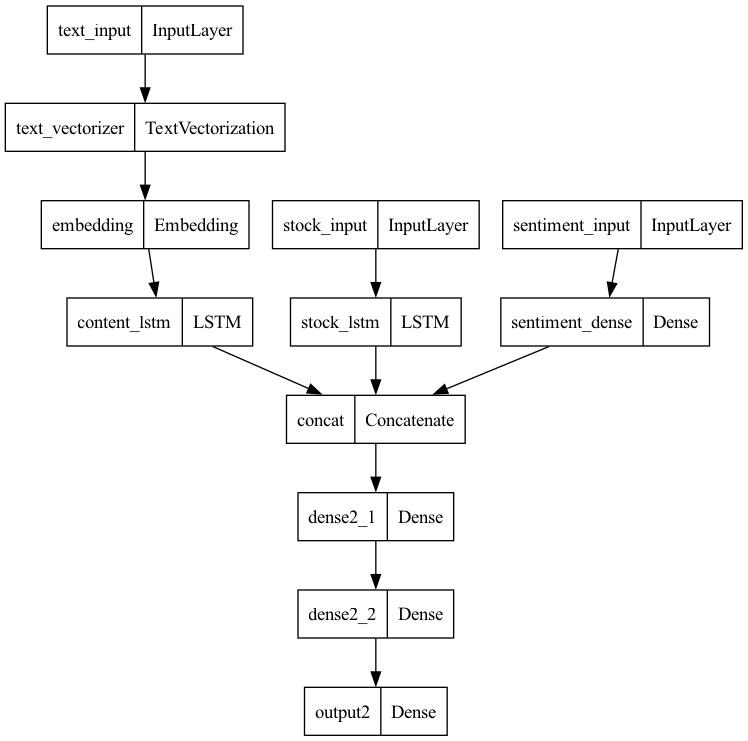

In [14]:
tf.random.set_seed(42)
np.random.seed(42)

stock_lstm_input = tf.keras.layers.Input(shape=(10, 1), name="stock_input")
stock_lstm = tf.keras.layers.LSTM(128, name="stock_lstm")(stock_lstm_input)

sentiment_input = tf.keras.layers.Input(shape=(17, ), name="sentiment_input")
sentiment_dense = tf.keras.layers.Dense(64, activation="relu", name="sentiment_dense")(sentiment_input)

content_input = tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name="text_input")
content_vectorized = vectorizer(content_input)
embedding = tf.keras.layers.Embedding(input_dim=vectorizer.vocabulary_size(), output_dim=128, name="embedding")(content_vectorized)
content_lstm = tf.keras.layers.LSTM(64, name="content_lstm")(embedding)

concat = tf.keras.layers.Concatenate(name="concat")([stock_lstm, sentiment_dense, content_lstm])

output2 = add_forecast_layer(concat, 2)

model = tf.keras.Model(
    inputs=[stock_lstm_input, sentiment_input, content_input],
    outputs=output2
)

model.compile(
    optimizer="adam", 
    loss=root_mean_squared_error,
)

tf.keras.utils.plot_model(model)

In [15]:
model.fit(
    [stock_seq_train, senti_indi_train, content_train],
    labels_train[["precise_forecast_2"]],
    epochs=5,
    validation_split=0.1
)

Epoch 1/5


2024-10-21 18:54:08.101917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:54:08.353124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:54:08.381252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:54:08.893363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:54:08.924767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - ETA: 0s - loss: 0.2096

2024-10-21 18:54:59.030304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:54:59.118658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:54:59.122624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


43/43 [==============================] - 53s 1s/step - loss: 0.2096 - val_loss: 0.1106
Epoch 2/5
43/43 [==============================] - 50s 1s/step - loss: 0.0820 - val_loss: 0.1044
Epoch 3/5
43/43 [==============================] - 50s 1s/step - loss: 0.0961 - val_loss: 0.1087
Epoch 4/5
43/43 [==============================] - 50s 1s/step - loss: 0.0880 - val_loss: 0.1191
Epoch 5/5
43/43 [==============================] - 50s 1s/step - loss: 0.1012 - val_loss: 0.1126


In [21]:
stock_seq_test, senti_indi_test, content_test, labels_test = neural_net_input(stock_data, X_test, y_test)
model.evaluate([stock_seq_test, senti_indi_test, content_test], labels_test)

6/6 [==============================] - 2s 250ms/step - loss: 0.1321


0.13214415311813354

In [17]:
def visualise_prediction(features, labels, train_sample = 0):
    start = features["timestamp"].iloc[train_sample]
    start_index = stock_data[stock_data["Datetime"] == start].index[0]
    sub = stock_data[["Close"]].iloc[start_index:start_index+31]
    sub = stock_scaler.inverse_transform(sub)
    plt.plot(sub)

    stock_seq, senti, content, labels = neural_net_input(stock_data, features, labels)

    predicted = model.predict([np.array([stock_seq[train_sample]]), np.array([senti.iloc[train_sample].values]), content.iloc[train_sample].values])
    predicted = stock_scaler.inverse_transform(np.reshape(predicted, (1, -1)))
    plt.scatter([5], predicted, c="red")
    plt.legend(["Actual", "Predicted"])

2024-10-21 18:58:23.459027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:58:23.546007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-10-21 18:58:23.552342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 487ms/step


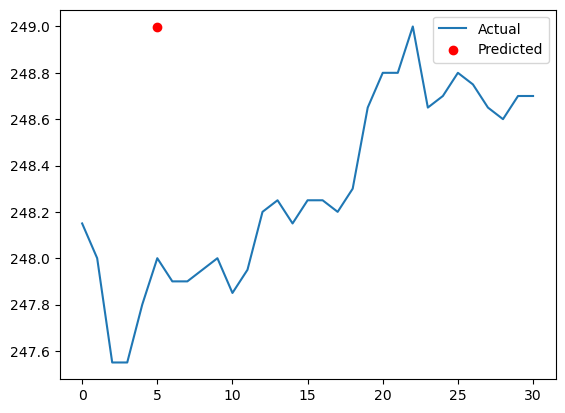

In [18]:
visualise_prediction(X_test, y_test, 2)

In [22]:
0.13214415311813354 * (stock_scaler.scale_)

array([1.78310011])

In [23]:
stock_scaler.mean_

array([243.73517504])